# Running the Lorenz model with synthetic observation using Data Assimilation in eWaterCycle

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
from tqdm import tqdm

In [2]:
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

Ensure ewatercycle-DA & the Lorenz model is installed

```py
pip install ewatercycle-DA
pip install ewatercycle-lorenz
```

In [3]:
from ewatercycle.forcing import sources

#### set up paths

In [5]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
figure_path = path / "Figures"
output_path = path / "Output"
for path in [forcing_path, observations_path, figure_path, output_path]:
    path.mkdir(exist_ok=True)

#### add parameter info

In [6]:
experiment_start_date = "1997-10-01T00:00:00Z"
experiment_end_date = "1997-10-10T00:00:00Z"

In [7]:
from ewatercycle.forcing import sources

In [8]:
lorenz_forcing = sources.LorenzForcing(start_time = experiment_start_date,
                                      end_time = experiment_end_date,
                                      directory = forcing_path,
                                      F = 8,
                                      dt=1e-3)

#### import model

In [9]:
from ewatercycle_DA import DA
from ewatercycle_DA.local_models.lorenz import LorenzLocal

The ewatercycle-Da package comes with a local lorenz model, however a docker version is also availible.
To use this ensure the package is installed:
```py
pip install ewatercycle-lorenz
```
then replace `LorenzLocal` with `Lorenz`

In [11]:
ewatercycle.models.sources

ModelSources[
    "HBV",
    "Lorenz"
]

In [12]:
n_particles = 10

In [13]:
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

In [14]:
J = 40
common_state = np.zeros(J)
common_state[19] = 0.01

#### petrub state every so slightly to start with:

In [15]:
rng = np.random.default_rng()
def add_normal_noise(like_sigma) -> float:
    """Normal (zero-mean) noise to be added to a state"""
    return rng.normal(loc=0, scale=like_sigma)

In [16]:
# values which you peturb
setup_kwargs_lst = []
for index in range(n_particles):
    peturbed_state = common_state.copy()
    peturbed_state[5] += add_normal_noise(0.01)
    setup_kwargs_lst.append({'J':J, 
                            'start_state':list(peturbed_state),
                             })

In [17]:
ensemble.initialize(model_name=["LorenzLocal"]*n_particles,
                    forcing=[lorenz_forcing]*n_particles,
                    setup_kwargs=setup_kwargs_lst)

## run truth model as observations

In [18]:
truth_model = LorenzLocal(forcing=lorenz_forcing)
config, _ = truth_model.setup(J=J,
                        start_state=list(common_state))
truth_model.initialize(config)

In [19]:
n_timesteps = int((truth_model.end_time - truth_model.start_time) /  truth_model.time_step)
output = pd.DataFrame(columns =['truth'])
output_lst = []
for _ in tqdm(range(n_timesteps)):   
    truth_model.update()
    output.loc[truth_model.time_as_datetime] = truth_model.get_value("state")[5]
    output_lst.append(truth_model.get_value("state"))
truth_model.finalize()

100%|████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:11<00:00, 762.71it/s]


In [20]:
output.index.name = "time"
current_time = str(datetime.now())[:-10].replace(":","_")
ds_obs_dir = observations_path / f'truth_model_lorenz96_{current_time}.nc'
ds_obs = xr.Dataset({'truth':xr.DataArray(data=pd.DataFrame(output,index=output.index),dims=["time","x"])})
if not ds_obs_dir.exists():
    ds_obs.to_netcdf(ds_obs_dir)

Highly chaotic system

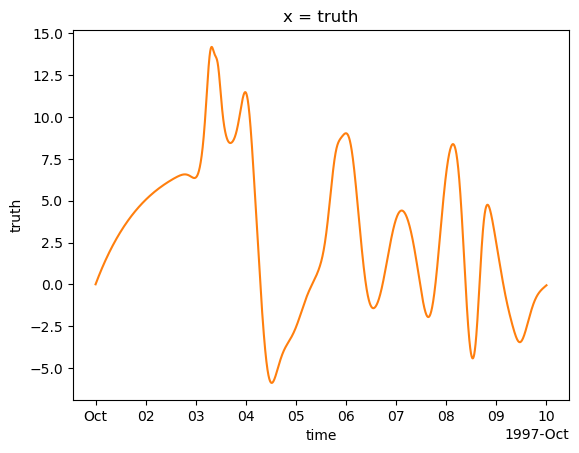

In [21]:
ds_obs['truth'].plot(color="C1");

## setup DA

This sets up all the require data assimilation information

In [22]:
def H(Z):
    """Function which takes the state vector Z and returns part of that state. 
    Returned should be same shape as data provided"""
    if len(Z) == J:
        return Z[5] 
    else: 
        raise SyntaxWarning(f"Length of statevector should be {J} but is {len(Z)}")

In [23]:
ensemble.initialize_da_method(ensemble_method_name = "PF", 
                           hyper_parameters = {
                                               'like_sigma_weights' : 0.05,
                                               'like_sigma_state_vector' : 0.8,
                                               'f_n_particles':1,
                                               },
                           state_vector_variables = ["state"],
                           observation_path = ds_obs_dir,
                           observed_variable_name = "truth",
                           measurement_operator= H                           
                            )

# Run

In [24]:
ref_model = ensemble.ensemble_list[0].model

In [25]:
assimilation_window = 10

In [26]:
n_timesteps = int((ref_model.end_time - ref_model.start_time) /  ref_model.time_step)
time = []
lst_state_vector = []
lst_Q = [] 
for i in tqdm(range(n_timesteps)):    
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    if i % assimilation_window == 0:  assimilate = True
    else:                             assimilate = False
    ensemble.update(assimilate)
    lst_state_vector.append(ensemble.get_state_vector())
ensemble.finalize()

100%|████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:57<00:00, 155.21it/s]


In [27]:
Q_m_arr = np.array(lst_Q).T
state_vector_arr = np.array(lst_state_vector)

### process the numpy data into easily acessed data types

In [28]:
save = False
current_time = str(datetime.now())[:-10].replace(":","_")

### process states and parameters into xarrys

In [29]:
data_vars = {}
for i, name in enumerate(range(J)):
    storage_terms_i = xr.DataArray(state_vector_arr[:,:,i].T,
                                   name=name,
                                   dims=["EnsembleMember","time"],
                                  coords=[np.arange(n_particles),time[:len(state_vector_arr)]],
                                  attrs={"title": f"Lorenz states over time for {n_particles} particles ", 
                                           "history": f"states of lorenz model: ewatercycle DA",
                                        "description":"Moddeled values",
                                             "units": "mm"})
    data_vars[name] = storage_terms_i

ds_combined = xr.Dataset(data_vars,
                         attrs={"title": f"Lorenz model over time for {n_particles} particles ", 
                                "history": f"states of lorenz model: ewatercycle DA",}
                          )

In [30]:
if save:
    ds_combined.to_netcdf(output_path / f'combined_ds_{current_time}.nc')

## Plotting

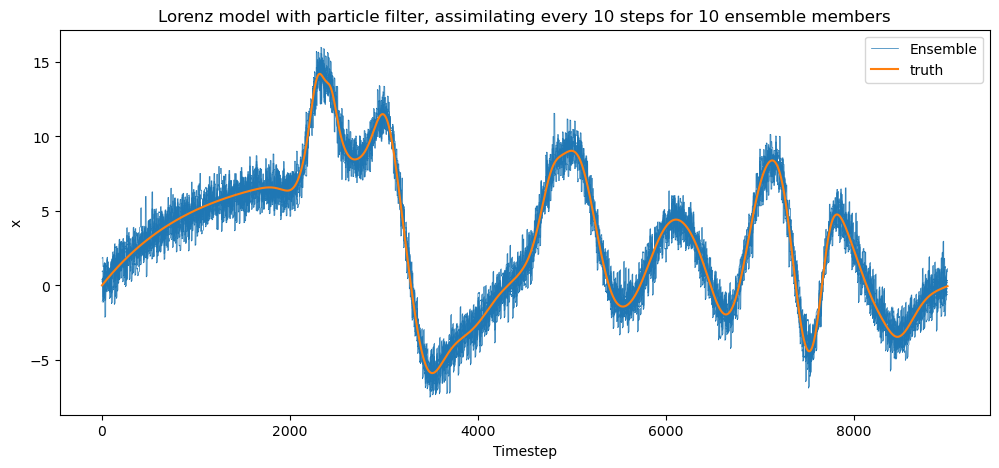

In [31]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
df_truth = ds_obs['truth'].to_pandas()
df_truth.index = range(len(ds_obs.time))
x_values = df_truth.index 
x = 1
for i in range(n_particles):
    ax.plot(x_values, ds_combined[x].isel(EnsembleMember=i).values,lw=0.5,color='C0',zorder=-1,label="Ensemble")
df_truth.plot(ax=ax,zorder=1, color="C1")
handels, labels =  ax.get_legend_handles_labels() 
ax.legend(handels[-2:],labels[-2:],title=None)
ax.set_xlabel('Timestep')
ax.set_ylabel('x')
ax.set_title(f"Lorenz model with particle filter, assimilating every {assimilation_window} steps for {n_particles} ensemble members")
if save: 
    fig.savefig(figure_path / "lorenz_model.png",bbox_inches="tight",dpi=400)